In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
import os

print(torch.__version__)

2.6.0


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = "cpu"
print(f"Using device : {device}")

Using device : mps


In [3]:
# Define dataset paths
train_dir = "CustomDataSet/data/train"
test_dir = "CustomDataSet/data/test"


In [4]:
# Define train and test transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))

])

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])



In [5]:
# Load datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [6]:
# Create dataloaders
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [7]:
from model import CustomCNN


In [8]:
model_0 = CustomCNN(num_classes=4)
model_0.to(device)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [9]:
class_names = train_data.classes
class_names

['donuts', 'french_fries', 'fried_rice', 'samosa']

In [10]:
class_dict = train_data.class_to_idx
class_dict

{'donuts': 0, 'french_fries': 1, 'fried_rice': 2, 'samosa': 3}

In [11]:
len(train_data), len(test_data)

(1834, 608)

In [12]:
from torchinfo import summary

summary(model=model_0,
        input_size=(32, 3, 128, 128),
        col_names=("input_size", "output_size", "num_params", "trainable"),
        col_width= 20,
        row_settings=["var_names"]
)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CustomCNN (CustomCNN)                    [32, 3, 128, 128]    [32, 4]              --                   True
├─Conv2d (conv1)                         [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
├─ReLU (relu)                            [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
├─MaxPool2d (pool)                       [32, 32, 128, 128]   [32, 32, 64, 64]     --                   --
├─Conv2d (conv2)                         [32, 32, 64, 64]     [32, 64, 64, 64]     18,496               True
├─ReLU (relu)                            [32, 64, 64, 64]     [32, 64, 64, 64]     --                   --
├─MaxPool2d (pool)                       [32, 64, 64, 64]     [32, 64, 32, 32]     --                   --
├─Conv2d (conv3)                         [32, 64, 32, 32]     [32, 128, 32, 32]    73,856               True
├─ReLU (relu)         

In [13]:
# Setu loss function and optimizer
criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                              lr=0.001,
                                weight_decay=1e-4)

In [14]:
from trainNN import train

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = train(
    model=model_0,
    train_dataloader=train_loader,
    test_dataloader= test_loader,
    optimizer=optimizer,
    loss_fn=criterian,
    epochs=20, 
    device=device

)

end_time = timer()
print(f"Total trainig time: {end_time - start_time:.3f}seconds")

/Users/sujannainawasti/.pyenv/versions/3.9.13/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  5%|▌         | 1/20 [00:08<02:50,  8.98s/it]

Epoch: 1 | train_loss: 1.4140 | train_acc: 0.3230 | test_loss: 1.3512 | test_acc: 0.3158


 10%|█         | 2/20 [00:16<02:24,  8.03s/it]

Epoch: 2 | train_loss: 1.3507 | train_acc: 0.3148 | test_loss: 1.3860 | test_acc: 0.3602


 15%|█▌        | 3/20 [00:25<02:23,  8.44s/it]

Epoch: 3 | train_loss: 1.3392 | train_acc: 0.3218 | test_loss: 1.3143 | test_acc: 0.3503


 20%|██        | 4/20 [00:37<02:37,  9.83s/it]

Epoch: 4 | train_loss: 1.3441 | train_acc: 0.3188 | test_loss: 1.3352 | test_acc: 0.3125


 25%|██▌       | 5/20 [00:49<02:39, 10.62s/it]

Epoch: 5 | train_loss: 1.3368 | train_acc: 0.3438 | test_loss: 1.3271 | test_acc: 0.3750


 30%|███       | 6/20 [01:01<02:35, 11.13s/it]

Epoch: 6 | train_loss: 1.3226 | train_acc: 0.3565 | test_loss: 1.2716 | test_acc: 0.4474


 35%|███▌      | 7/20 [01:13<02:27, 11.36s/it]

Epoch: 7 | train_loss: 1.3191 | train_acc: 0.3583 | test_loss: 1.2419 | test_acc: 0.4227


 40%|████      | 8/20 [01:25<02:19, 11.60s/it]

Epoch: 8 | train_loss: 1.3102 | train_acc: 0.3548 | test_loss: 1.2803 | test_acc: 0.3997


 45%|████▌     | 9/20 [01:37<02:09, 11.79s/it]

Epoch: 9 | train_loss: 1.3152 | train_acc: 0.3696 | test_loss: 1.2057 | test_acc: 0.4408


 50%|█████     | 10/20 [01:49<01:58, 11.86s/it]

Epoch: 10 | train_loss: 1.2838 | train_acc: 0.3828 | test_loss: 1.2660 | test_acc: 0.4868


 55%|█████▌    | 11/20 [02:02<01:48, 12.06s/it]

Epoch: 11 | train_loss: 1.2618 | train_acc: 0.3952 | test_loss: 1.2076 | test_acc: 0.4934


 60%|██████    | 12/20 [02:14<01:36, 12.03s/it]

Epoch: 12 | train_loss: 1.2463 | train_acc: 0.4138 | test_loss: 1.0948 | test_acc: 0.5132


 65%|██████▌   | 13/20 [02:25<01:24, 12.01s/it]

Epoch: 13 | train_loss: 1.2291 | train_acc: 0.4317 | test_loss: 1.0499 | test_acc: 0.5444


 70%|███████   | 14/20 [02:37<01:11, 11.99s/it]

Epoch: 14 | train_loss: 1.2134 | train_acc: 0.4376 | test_loss: 1.1743 | test_acc: 0.4934


 75%|███████▌  | 15/20 [02:49<00:59, 11.99s/it]

Epoch: 15 | train_loss: 1.2243 | train_acc: 0.4434 | test_loss: 1.1820 | test_acc: 0.5033


 80%|████████  | 16/20 [03:01<00:47, 11.98s/it]

Epoch: 16 | train_loss: 1.2021 | train_acc: 0.4489 | test_loss: 1.0469 | test_acc: 0.5609


 85%|████████▌ | 17/20 [03:13<00:35, 11.97s/it]

Epoch: 17 | train_loss: 1.1641 | train_acc: 0.4635 | test_loss: 0.9959 | test_acc: 0.5954


 90%|█████████ | 18/20 [03:25<00:24, 12.02s/it]

Epoch: 18 | train_loss: 1.1810 | train_acc: 0.4664 | test_loss: 1.1933 | test_acc: 0.5099


 95%|█████████▌| 19/20 [03:37<00:11, 11.99s/it]

Epoch: 19 | train_loss: 1.1491 | train_acc: 0.4736 | test_loss: 1.0315 | test_acc: 0.5822


100%|██████████| 20/20 [03:49<00:00, 11.49s/it]

Epoch: 20 | train_loss: 1.1260 | train_acc: 0.4909 | test_loss: 1.0736 | test_acc: 0.5888
Total trainig time: 229.814seconds


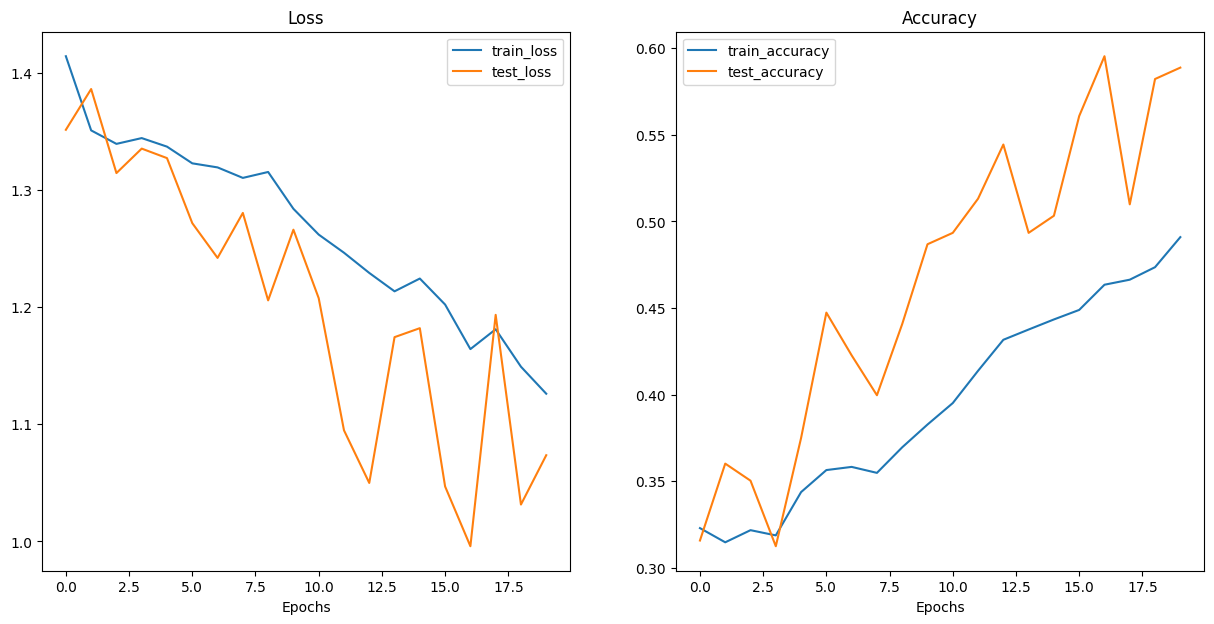

In [15]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [16]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "modelv0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/modelv0.pth
